**CONSOLIDATED**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!pip install afinn

In [159]:
# Import libraries 
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype 
from sklearn import model_selection, metrics
from afinn import Afinn
import math



In [201]:
# df = pd.read_csv("/content/gdrive/MyDrive/Combined_dataset.csv")
df = pd.read_csv("./Output/Combined_dataset.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

(3429, 33)


In [202]:
#Get name of cols
for i in range(0,32):
    print(df.columns[i])

id_row
backers_count
blurb
category
converted_pledged_amount
country
created_at
current_currency
deadline
fx_rate
goal
id
launched_at
location
name
pledged
profile
slug
source_url
spotlight
staff_pick
state
state_changed_at
static_usd_rate
urls
usd_pledged
usd_type
story
faq
num_faq
comments
n_comments


In [203]:
df.head(2)

,id_row,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,...,static_usd_rate,urls,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration
0,0,1,With your help we will create this device that...,"{""id"":331,""name"":""3D Printing"",""slug"":""technol...",1,ES,2015-08-18 21:01:19,USD,2016-07-09 20:11:23,1.212886,...,1.136930,"{""web"":{""project"":""https://www.kickstarter.com...",1.136930,domestic,Producto Final\nHi! The funds we will used to ...,[' '],0.0,Only backers can post comments. Log in\nAnaTal...,1,30 days 00:00:00
1,1,2,We at Ormiston Primary are looking at starting...,"{""id"":309,""name"":""Farms"",""slug"":""food/farms"",""...",9,NZ,2015-08-11 18:04:21,USD,2015-09-11 15:55:41,0.723585,...,0.655304,"{""web"":{""project"":""https://www.kickstarter.com...",9.829555,domestic,Producto Final\nHi! The funds we will used to ...,[' '],0.0,Only backers can post comments. Log in\nNo com...,0,30 days 00:00:00


In [204]:
# Drop Duplicates
df = df.drop_duplicates('id', keep ='first')

In [205]:
#Check for NA
df.isna().sum()

id_row                         0
backers_count                  0
blurb                          0
category                       0
converted_pledged_amount       0
country                        0
created_at                     0
current_currency               0
deadline                       0
fx_rate                        0
goal                           0
id                             0
launched_at                    0
location                       5
name                           0
pledged                        0
profile                        0
slug                           0
source_url                     0
spotlight                      0
staff_pick                     0
state                          0
state_changed_at               0
static_usd_rate                0
urls                           0
usd_pledged                    0
usd_type                       0
story                       2429
faq                         2419
num_faq                        0
comments  

In [ ]:
df['location'] = df.location.fillna('NA') # Fill up NAs first 

In [207]:
# Convert numerical cols type to int/float
df['duration'] = pd.to_numeric(pd.to_timedelta(df['duration']).dt.days, downcast='integer')
df['num_faq'] = df['num_faq'].astype(int)
df['n_comments'] = df['n_comments'].str.replace(',', '').astype(float)

# Convert rows from str to dict
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", "'").replace('u"', '"')
    return json.loads(dict_string)

df.category = df.category.apply(string_to_dict)

# Get category values from dictionary
df['parent_category'] = [d.get('parent_name') for d in df.category]
df['category_name'] = [d.get('name') for d in df.category]
df["parent_category"].fillna("No Parent Category", inplace = True)

# Get Location of Projects from location dict
def get_location(i):
    if i != 'NA':
        # i = str(i).replace('nan', '{"name": ""}') # Commenting this line out for now - place names with 'nan' in it are tripping
        i = i.replace('false', 'False')
        i = i.replace('null', '{"name": ""}')
        name_i = eval(i).get('name')
        if len(name_i) == 0:
            return None
        else:
            if name_i.isdigit():
                return None
            else:
                return name_i

df['location_name'] = df.location.apply(lambda x: get_location(x))

In [210]:
# Fill na for text cols
df["story"].fillna(" ", inplace = True)

# Clean up comments 
df['comments'] = df['comments'].apply(lambda x: x.replace('Only backers can post comments. Log in\n',"") )

print(df.shape)
df.sample(3)

(3419, 36)


,id_row,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,...,usd_type,story,faq,num_faq,comments,n_comments,duration,parent_category,category_name,location_name
834,834,16,A new perspective on Adam and Eve.,"{'id': 23, 'name': 'Painting', 'slug': 'art/pa...",6015,US,2012-08-02 14:45:12,USD,2012-09-20 02:59:00,1.0,...,domestic,What is The Glebe Exhibit?\nThe Glebe Exhibit ...,[' '],0,BCreator\nover 3 years ago\nYes they are in th...,2.0,35,Art,Painting,Los Angeles
83,83,30,The Glebe Exhibit is a fundraiser for an art g...,"{'id': 54, 'name': 'Mixed Media', 'slug': 'art...",4740,US,2020-02-29 12:52:48,USD,2020-03-31 23:05:00,1.0,...,domestic,As an answer to the spontaneous and complex we...,[' '],0,No comments yet.,0.0,29,Art,Mixed Media,Omaha
2364,2364,1,The White Witch Paranormal Museum is museum de...,"{'id': 53, 'name': 'Public Art', 'slug': 'art/...",30,US,2015-01-04 20:21:36,USD,2015-02-20 20:34:57,1.0,...,domestic,,NaN,0,,0.0,30,Art,Public Art,Green Bay


In [211]:
#Get name of cols (after clean)
for i in range(0,34):
    print(df.columns[i])

id_row
backers_count
blurb
category
converted_pledged_amount
country
created_at
current_currency
deadline
fx_rate
goal
id
launched_at
location
name
pledged
profile
slug
source_url
spotlight
staff_pick
state
state_changed_at
static_usd_rate
urls
usd_pledged
usd_type
story
faq
num_faq
comments
n_comments
duration
parent_category


## EDA

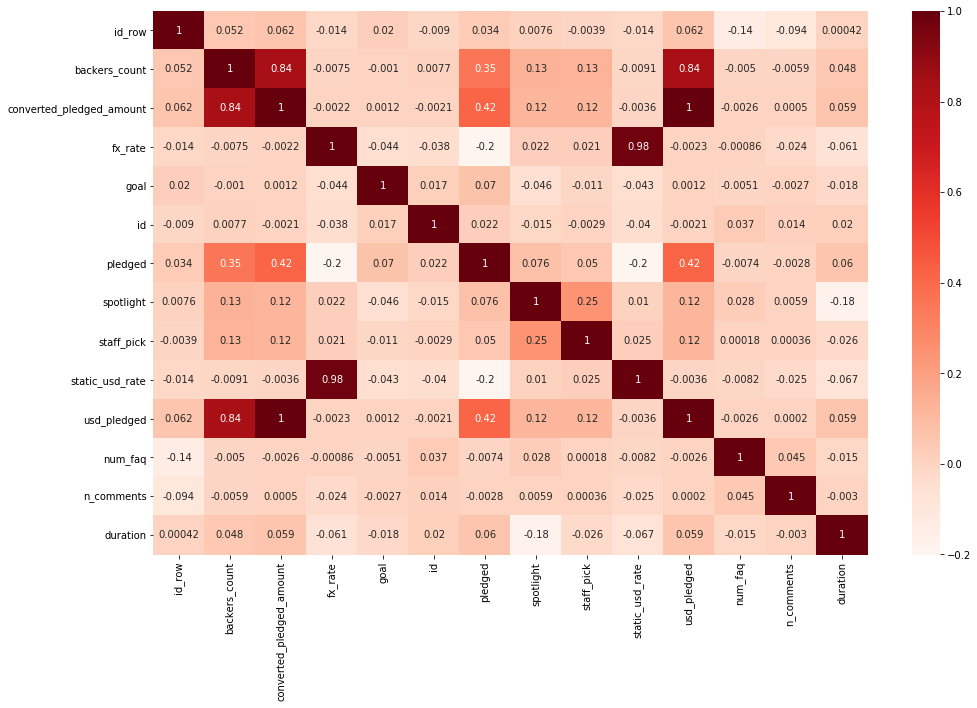

In [212]:
# Get Correlation heatmap
plt.figure(figsize=(16,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Features with high correlation: 

1. converted_pledged_amount with usd_pledged,
2. static_usd_rate with fx_rate
3. usd_pledged with backers_count
4. state with spotlight
5. n_comments with converted_pledged_amount
6. n_comments with backers_count
7. converted_pledged_amount with converted_pledged_amount



## Feature Engineering

In [213]:
# Separate cols by type
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name']
num_cols = ['backers_count', 'fx_rate', 'goal', 'pledged', 'num_faq', 'n_comments', 'duration']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments']

In [214]:
#Change state to binary (1 = success project, 0 = failed project)
df.state = df.state.astype('category').cat.codes

In [215]:
# Get month/year of launch/deadline
df['month_launched'] = pd.DatetimeIndex(df['launched_at']).month.astype(int)
df['year_launched'] = pd.DatetimeIndex(df['launched_at']).year.astype(int)

In [216]:
# Log Transformation
boxplot_features = ['backers_count', 'goal', 'pledged', 'duration', 'n_comments']

for feature in boxplot_features:
    new_col = feature + '_log'
    df[new_col] = df[feature].apply(lambda x: math.log(x+1))
    df[new_col] = (df[new_col] - df[new_col].mean())/df[new_col].std()

In [217]:
# Boolean Transformation
df['num_faq_bool'] = df['num_faq'].apply(lambda x: np.where(x >0, 1, 0))

In [218]:
# Average fund per backer
df['avg_fund_per_backer'] = df['pledged']/df['backers_count']
num_cols.append('avg_fund_per_backer')

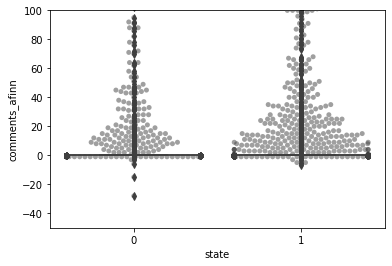

In [219]:
# Add Afinn score for comments
afinn = Afinn(emoticons=True)
afinn_scores = [afinn.score(text) for text in df.comments]
df['comments_afinn'] = afinn_scores

sns.boxplot(x="state", y="comments_afinn", data=df).set(ylim=(-50, 100))
sns.swarmplot(x="state", y="comments_afinn", data=df, color=".25", alpha=0.5)

## Text Analysis

In [220]:
# Extra text features to be analyzed by combining pre-existing text features
df['blurb_name'] = df['blurb'] + df['name']
# df['blurb_story'] = df['blurb'] + df['story']
# df['name_faq'] = df['name'] + df['faq']
# df['name_comments'] = df['name'] + df['comments']
df['faq_comments'] = df['faq'] + df['comments']

text_cols2 = ['blurb_name', 'faq_comments']
text_cols = text_cols + text_cols2

Save to output csv

In [221]:
df.columns

Index(['id_row', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'current_currency',
       'deadline', 'fx_rate', 'goal', 'id', 'launched_at', 'location', 'name',
       'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'staff_pick',
       'state', 'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type', 'story', 'faq', 'num_faq', 'comments', 'n_comments',
       'duration', 'parent_category', 'category_name', 'location_name',
       'month_launched', 'year_launched', 'backers_count_log', 'goal_log',
       'pledged_log', 'duration_log', 'n_comments_log', 'num_faq_bool',
       'avg_fund_per_backer', 'comments_afinn', 'blurb_name', 'faq_comments'],
      dtype='object')

In [222]:
df.sample(3)

,id_row,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,...,backers_count_log,goal_log,pledged_log,duration_log,n_comments_log,num_faq_bool,avg_fund_per_backer,comments_afinn,blurb_name,faq_comments
2061,2061,97,"After 5 years of growing my business, it's tim...","{'id': 312, 'name': 'Restaurants', 'slug': 'fo...",11262,US,2019-08-16 00:07:56,USD,2019-09-29 12:51:52,1.000000,...,0.648825,0.471397,0.773220,-0.023896,-0.331095,0,116.103093,0.0,"After 5 years of growing my business, it's tim...",NaN
2549,2549,30,Monster enamel pins,"{'id': 267, 'name': 'Jewelry', 'slug': 'fashio...",682,GB,2020-11-27 08:56:39,USD,2020-12-31 08:35:01,1.384815,...,0.047455,-1.651638,-0.192018,-0.023896,-0.331095,0,16.700000,0.0,Monster enamel pinsIsolation Monster: enamel pins,NaN
1295,1295,37,Elemental is a superhero who can transform int...,"{'id': 252, 'name': 'Graphic Novels', 'slug': ...",1121,GB,2015-03-05 07:50:01,USD,2015-05-05 12:02:04,1.382164,...,0.153832,-0.972854,-0.070352,1.788987,-0.331095,0,20.054054,0.0,Elemental is a superhero who can transform int...,NaN


In [223]:
df["location_name"].fillna("None", inplace = True)
df["location"].fillna("None", inplace = True)
df["avg_fund_per_backer"].fillna(0, inplace = True)

In [224]:
df.isna().sum()

id_row                         0
backers_count                  0
blurb                          0
category                       0
converted_pledged_amount       0
country                        0
created_at                     0
current_currency               0
deadline                       0
fx_rate                        0
goal                           0
id                             0
launched_at                    0
location                       0
name                           0
pledged                        0
profile                        0
slug                           0
source_url                     0
spotlight                      0
staff_pick                     0
state                          0
state_changed_at               0
static_usd_rate                0
urls                           0
usd_pledged                    0
usd_type                       0
story                          0
faq                         2419
num_faq                        0
comments  

In [227]:
# from google.colab import files
df.to_csv('Output/data_clean&processed.csv')
# files.download('data_clean&processed.csv')  